In [1]:
import sys
sys.path.append('../') 
from imports import *


## Models / hypothesis class

#### things to do:
1. test every model using train, val, test set
2. hyperparameter tuning (optuna / weights and biases / tensorboard)

### Models to do: 
1. Logistic Regression with and without regularization

In [2]:
# Loading the datasets
X_train = pd.read_csv('./breast-cancer-processed-data/X_train.csv')
y_train = pd.read_csv('./breast-cancer-processed-data/y_train.csv') 
X_val = pd.read_csv('./breast-cancer-processed-data/X_val.csv')
y_val = pd.read_csv('./breast-cancer-processed-data/y_val.csv')
X_test = pd.read_csv('./breast-cancer-processed-data/X_test.csv')
y_test = pd.read_csv('./breast-cancer-processed-data/y_test.csv')


In [3]:
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

# Logistic regression without regularization

In [4]:
# Initialize the Logistic Regression model without regularization
log_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1)

# Train the model on the training set
log_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = log_reg.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

# If the validation performance is satisfactory, evaluate on the test set (at the last) after with and without regularization
# y_test_pred = log_reg.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f"Test Set Accuracy: {test_accuracy:.4f}")


Validation Set Accuracy: 0.9341


## not using accuracy_score since the dataset is imbalanced and using roc_auc_scor and precision_score

In [5]:
# Predict probabilities
y_val_probs = log_reg.predict_proba(X_val)[:, 1]

# Compute AUROC
auroc = roc_auc_score(y_val, y_val_probs)
print(f"Area under the ROC curve: {auroc:.2f}")

# Compute Precision-Recall curve and its area
average_precision = average_precision_score(y_val, y_val_probs)
print(f"Area under the Precision-Recall curve: {average_precision:.2f}")

Area under the ROC curve: 0.94
Area under the Precision-Recall curve: 0.93


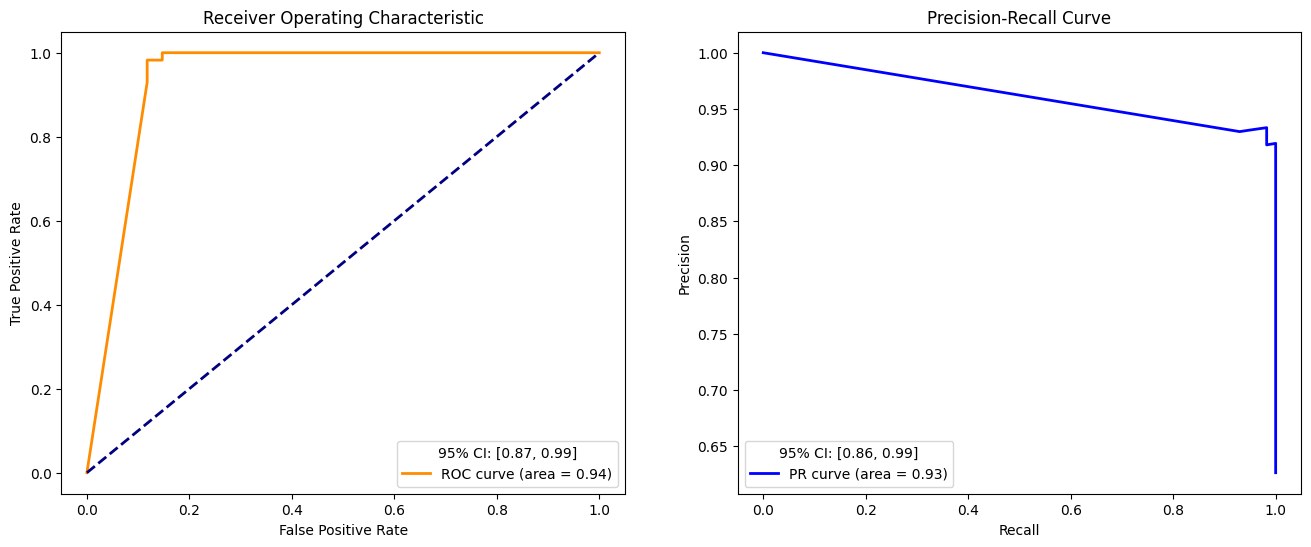

In [6]:
# Number of bootstrap samples
n_bootstraps = 1000
bootstrap_auroc_scores = []
bootstrap_average_precision_scores = []

# Ensure y_val is a Pandas Series for consistency
y_val = y_val.squeeze()

for _ in range(n_bootstraps):
    # Bootstrap sample (with replacement)
    indices = resample(np.arange(len(y_val)), replace=True)
    y_val_boot = y_val.iloc[indices]
    y_val_probs_boot = y_val_probs[indices]

    # Compute metrics for bootstrap sample
    bootstrap_auroc_scores.append(roc_auc_score(y_val_boot, y_val_probs_boot))
    bootstrap_average_precision_scores.append(average_precision_score(y_val_boot, y_val_probs_boot))

# Compute confidence intervals for AUC
auroc_lower = np.percentile(bootstrap_auroc_scores, 2.5)
auroc_upper = np.percentile(bootstrap_auroc_scores, 97.5)
ap_lower = np.percentile(bootstrap_average_precision_scores, 2.5)
ap_upper = np.percentile(bootstrap_average_precision_scores, 97.5)

# Original ROC and PR curves
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
precision, recall, _ = precision_recall_curve(y_val, y_val_probs)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right", title=f'95% CI: [{auroc_lower:.2f}, {auroc_upper:.2f}]')

# Precision-Recall Curve
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {average_precision:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left", title=f'95% CI: [{ap_lower:.2f}, {ap_upper:.2f}]')

plt.show()


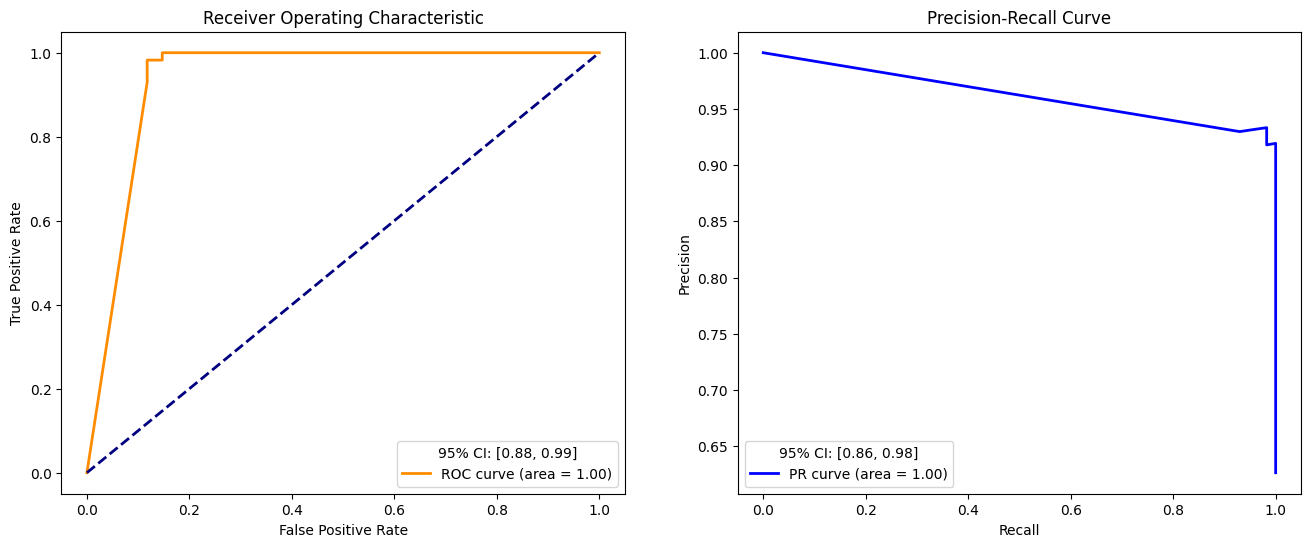

In [7]:
# Initialize the Logistic Regression model with L1 regularization
# You may need to tune the 'C' parameter using the validation set
log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=1000, random_state=1)

# Train the model on the training set
log_reg_l1.fit(X_train, y_train)

# Predict probabilities for the validation and test sets
y_val_probs_l1 = log_reg_l1.predict_proba(X_val)[:, 1]
y_test_probs_l1 = log_reg_l1.predict_proba(X_test)[:, 1]

# Compute the AUROC and average precision score on the validation set
val_auroc = roc_auc_score(y_val, y_val_probs_l1)
val_average_precision = average_precision_score(y_val, y_val_probs_l1)

# Compute the AUROC and average precision score on the test set
test_auroc = roc_auc_score(y_test, y_test_probs_l1)
test_average_precision = average_precision_score(y_test, y_test_probs_l1)

# Perform bootstrapping for confidence intervals
n_bootstraps = 1000
bootstrap_auroc_scores = []
bootstrap_average_precision_scores = []

for _ in range(n_bootstraps):
    # Bootstrap sample (with replacement)
    indices = resample(np.arange(len(y_val)), replace=True)
    y_val_boot = y_val.iloc[indices]
    y_val_probs_boot = y_val_probs[indices]

    # Compute metrics for bootstrap sample
    bootstrap_auroc_scores.append(roc_auc_score(y_val_boot, y_val_probs_boot))
    bootstrap_average_precision_scores.append(average_precision_score(y_val_boot, y_val_probs_boot))

# Compute confidence intervals
auroc_lower = np.percentile(bootstrap_auroc_scores, 2.5)
auroc_upper = np.percentile(bootstrap_auroc_scores, 97.5)
ap_lower = np.percentile(bootstrap_average_precision_scores, 2.5)
ap_upper = np.percentile(bootstrap_average_precision_scores, 97.5)

# Plot the curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {val_auroc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right", title=f'95% CI: [{auroc_lower:.2f}, {auroc_upper:.2f}]')

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_val, y_val_probs)
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {val_average_precision:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left", title=f'95% CI: [{ap_lower:.2f}, {ap_upper:.2f}]')

plt.show()


Best C value: 0.1 with AUROC: 0.9990


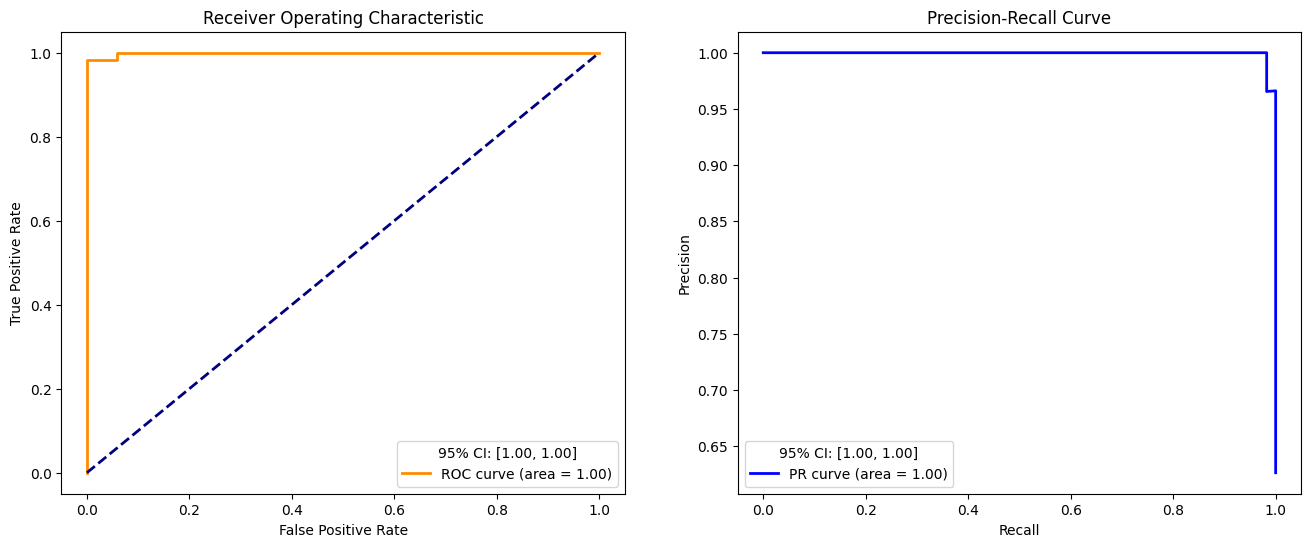

In [8]:
# Define a set of C values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Initialize variables to store the best score and corresponding C value
best_score = 0
best_C = None

# Perform grid search over the C values
for C in C_values:
    # Initialize and train the Logistic Regression model with L1 regularization
    log_reg_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=1000, random_state=1)
    log_reg_l1.fit(X_train, y_train)

    # Evaluate on the validation set
    y_val_probs = log_reg_l1.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_val_probs)

    # If the score is better than the best score, update the best score and best C
    if score > best_score:
        best_score = score
        best_C = C

# Output the best C value
print(f"Best C value: {best_C} with AUROC: {best_score:.4f}")

# Train a new model using the best C value
best_log_reg_l1 = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', max_iter=1000, random_state=1)
best_log_reg_l1.fit(X_train, y_train)

# Continue with bootstrapping, plotting, and evaluation using the best_log_reg_l1 model

# Predict probabilities for the validation and test sets
y_val_probs_l1 = best_log_reg_l1.predict_proba(X_val)[:, 1]
y_test_probs_l1 = best_log_reg_l1.predict_proba(X_test)[:, 1]

# Compute the AUROC and average precision score on the validation set
val_auroc_l1 = roc_auc_score(y_val, y_val_probs_l1)
val_average_precision_l1 = average_precision_score(y_val, y_val_probs_l1)

# Compute the AUROC and average precision score on the test set
test_auroc_l1 = roc_auc_score(y_test, y_test_probs_l1)
test_average_precision_l1 = average_precision_score(y_test, y_test_probs_l1)

# Perform bootstrapping for confidence intervals
n_bootstraps = 1000
bootstrap_auroc_scores_l1 = []
bootstrap_average_precision_scores_l1 = []

for _ in range(n_bootstraps):
    # Bootstrap sample (with replacement)
    indices = resample(np.arange(len(y_val)), replace=True)
    y_val_boot = y_val.iloc[indices]
    y_val_probs_boot_l1 = y_val_probs_l1[indices]

    # Compute metrics for bootstrap sample
    bootstrap_auroc_scores_l1.append(roc_auc_score(y_val_boot, y_val_probs_boot_l1))
    bootstrap_average_precision_scores_l1.append(average_precision_score(y_val_boot, y_val_probs_boot_l1))

# Compute confidence intervals
auroc_lower_l1 = np.percentile(bootstrap_auroc_scores_l1, 2.5)
auroc_upper_l1 = np.percentile(bootstrap_auroc_scores_l1, 97.5)
ap_lower_l1 = np.percentile(bootstrap_average_precision_scores_l1, 2.5)
ap_upper_l1 = np.percentile(bootstrap_average_precision_scores_l1, 97.5)

# Plot the curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot ROC curve
fpr_l1, tpr_l1, _ = roc_curve(y_val, y_val_probs_l1)
ax1.plot(fpr_l1, tpr_l1, color='darkorange', lw=2, label=f'ROC curve (area = {val_auroc_l1:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right", title=f'95% CI: [{auroc_lower_l1:.2f}, {auroc_upper_l1:.2f}]')

# Plot Precision-Recall curve
precision_l1, recall_l1, _ = precision_recall_curve(y_val, y_val_probs_l1)
ax2.plot(recall_l1, precision_l1, color='blue', lw=2, label=f'PR curve (area = {val_average_precision_l1:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left", title=f'95% CI: [{ap_lower_l1:.2f}, {ap_upper_l1:.2f}]')

plt.show()



In [9]:
def plot_roc_pr_curves(y_true, y_probs, n_bootstraps=1000):
    # Perform bootstrapping to calculate the confidence intervals
    bootstrap_auroc_scores = []
    bootstrap_average_precision_scores = []

    for _ in range(n_bootstraps):
        # Bootstrap sample (with replacement)
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_boot = y_true.iloc[indices]
        y_probs_boot = y_probs[indices]

        # Compute metrics for bootstrap sample
        bootstrap_auroc_scores.append(roc_auc_score(y_true_boot, y_probs_boot))
        bootstrap_average_precision_scores.append(average_precision_score(y_true_boot, y_probs_boot))

    # Compute confidence intervals
    auroc_lower = np.percentile(bootstrap_auroc_scores, 2.5)
    auroc_upper = np.percentile(bootstrap_auroc_scores, 97.5)
    ap_lower = np.percentile(bootstrap_average_precision_scores, 2.5)
    ap_upper = np.percentile(bootstrap_average_precision_scores, 97.5)

    # Calculate original ROC and PR curves
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    auroc = roc_auc_score(y_true, y_probs)
    average_precision = average_precision_score(y_true, y_probs)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right", title=f'95% CI: [{auroc_lower:.2f}, {auroc_upper:.2f}]')

    # Precision-Recall Curve
    ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {average_precision:.2f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left", title=f'95% CI: [{ap_lower:.2f}, {ap_upper:.2f}]')

    plt.show()

    # Return the confidence intervals
    return (auroc_lower, auroc_upper), (ap_lower, ap_upper)




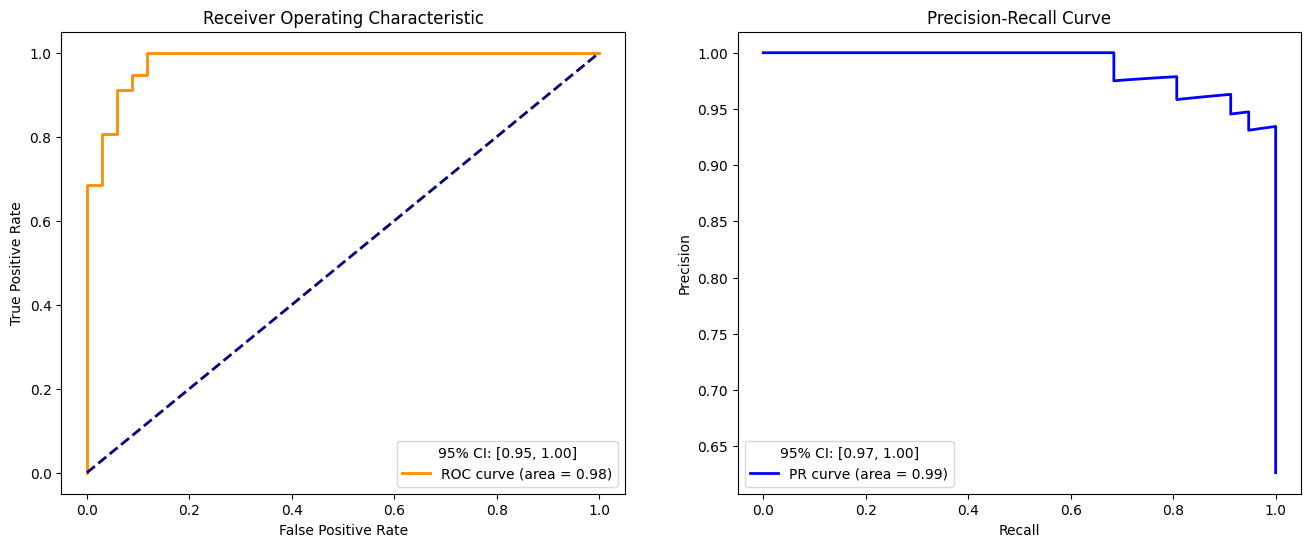

In [10]:
# Example usage:
# Assuming y_val is your true labels and y_val_probs are the predicted probabilities
auroc_confidence_interval, ap_confidence_interval = plot_roc_pr_curves(y_val, y_val_probs)

In [11]:
# Define a set of C values to try
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Initialize variables to store the best score and corresponding C value
best_score = 0
best_C = None

# Perform grid search over the C values
for C in C_values:
    # Initialize and train the Logistic Regression model with L1 regularization
    log_reg_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=1000, random_state=1)
    log_reg_l1.fit(X_train, y_train)

    # Evaluate on the validation set
    y_val_probs = log_reg_l1.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_val_probs)

    # If the score is better than the best score, update the best score and best C
    if score > best_score:
        best_score = score
        best_C = C

# Output the best C value
print(f"Best C value: {best_C} with AUROC: {best_score:.4f}")

# Train a new model using the best C value
best_log_reg_l1 = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', max_iter=1000, random_state=1)
best_log_reg_l1.fit(X_train, y_train)

# Continue with bootstrapping, plotting, and evaluation using the best_log_reg_l1 model

# Predict probabilities for the validation and test sets
y_val_probs_l1 = best_log_reg_l1.predict_proba(X_val)[:, 1]

Best C value: 0.1 with AUROC: 0.9990


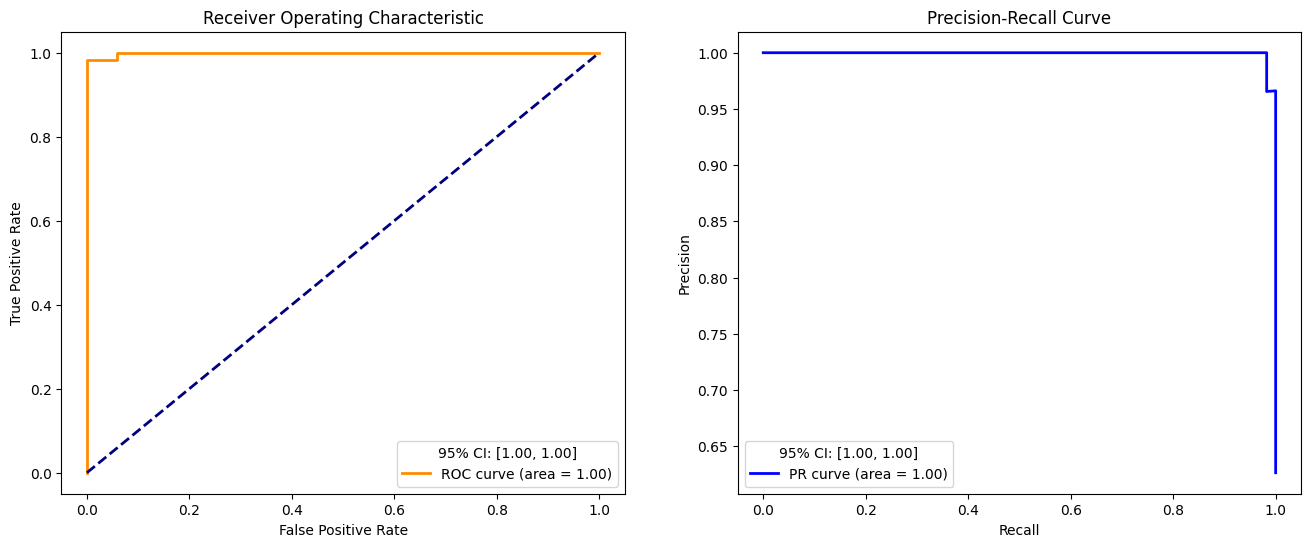

In [12]:
auroc_confidence_interval_l1, ap_confidence_interval_l1 = plot_roc_pr_curves(y_val, y_val_probs_l1)

# L2 regularization

In [13]:
# Define a logistic regression model. Note: The default penalty is 'l2'.
log_reg_l2 = LogisticRegression(solver='liblinear', random_state=1)

# Define the hyperparameter grid for 'C'. This range is quite broad, feel free to refine it based on results.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Define the scoring function you want to optimize for during the grid search
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(log_reg_l2, param_grid, cv=5, scoring=scorer)

# Perform grid search on the training set
grid_search.fit(X_train, y_train)

# After grid search, the best hyperparameter value is stored in 'best_estimator_'
best_log_reg_l2 = grid_search.best_estimator_

# Now you can use 'best_l2_model' to make predictions and evaluate it
y_val_probs_l2 = best_log_reg_l2.predict_proba(X_val)[:, 1]
y_test_probs_l2 = best_log_reg_l2.predict_proba(X_test)[:, 1]

# Evaluate the model using the validation and test sets (as per your project's requirements)
val_auroc_l2 = roc_auc_score(y_val, y_val_probs_l2)
test_auroc_l2 = roc_auc_score(y_test, y_test_probs_l2)

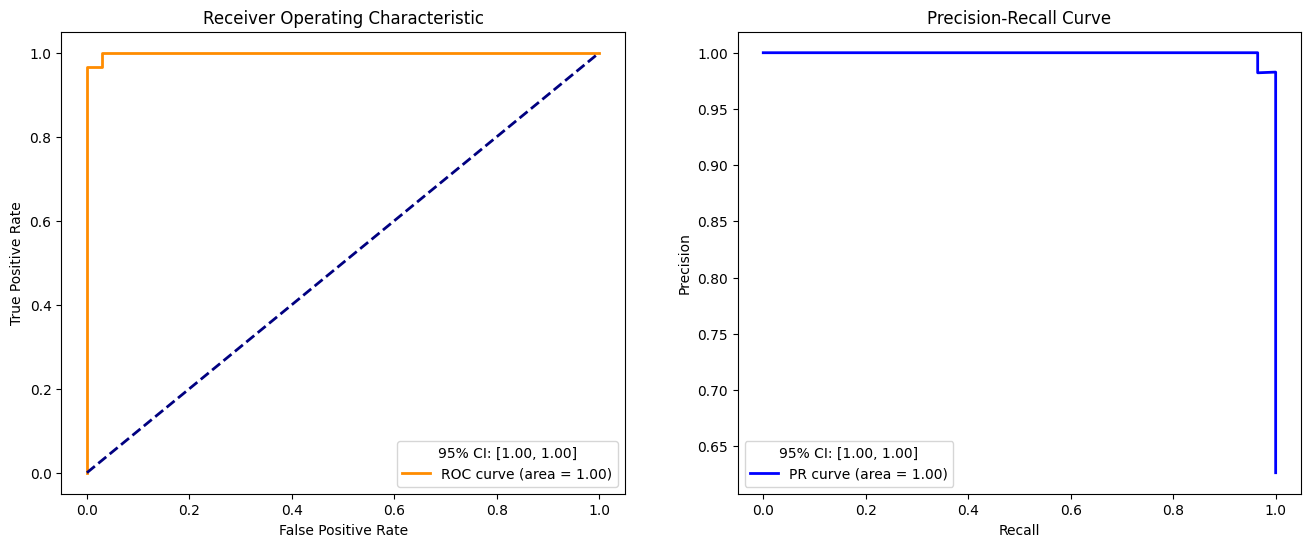

In [14]:
auroc_confidence_interval_l2, ap_confidence_interval_l2 = plot_roc_pr_curves(y_val, y_val_probs_l2)

# Feature importance for L1, L2 regularization

In [15]:
# Get the coefficients from the L1 model
log_reg_l1_coefficients = best_log_reg_l1.coef_.flatten()

# Get the coefficients from the L2 model
log_reg_l2_coefficients = best_log_reg_l2.coef_.flatten()

# For better interpretability, you might want to look at the absolute values of the coefficients
log_reg_l1_importance = np.abs(log_reg_l1_coefficients)
log_reg_l2_importance = np.abs(log_reg_l2_coefficients)

# Create a DataFrame for easy viewing of feature importance for both models
import pandas as pd

feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'L1 Coefficient': log_reg_l1_coefficients,
    'L1 Importance': log_reg_l1_importance,
    'L2 Coefficient': log_reg_l2_coefficients,
    'L2 Importance': log_reg_l2_importance,
}).sort_values('L1 Importance', ascending=False)

print(importance_df)


                    Feature  L1 Coefficient  L1 Importance  L2 Coefficient  \
20             worst radius       -1.683891       1.683891       -0.482595   
27     worst concave points       -1.092419       1.092419       -0.486204   
21            worst texture       -0.529278       0.529278       -0.508982   
10             radius error       -0.488518       0.488518       -0.474006   
7       mean concave points       -0.382512       0.382512       -0.400012   
24         worst smoothness       -0.185205       0.185205       -0.396941   
28           worst symmetry       -0.035923       0.035923       -0.364692   
0               mean radius        0.000000       0.000000       -0.322881   
16          concavity error        0.000000       0.000000        0.091837   
26          worst concavity        0.000000       0.000000       -0.371981   
25        worst compactness        0.000000       0.000000       -0.146645   
23               worst area        0.000000       0.000000      

In [16]:
importance_df

,Feature,L1 Coefficient,L1 Importance,L2 Coefficient,L2 Importance
20,worst radius,-1.683891,1.683891,-0.482595,0.482595
27,worst concave points,-1.092419,1.092419,-0.486204,0.486204
21,worst texture,-0.529278,0.529278,-0.508982,0.508982
10,radius error,-0.488518,0.488518,-0.474006,0.474006
7,mean concave points,-0.382512,0.382512,-0.400012,0.400012
24,worst smoothness,-0.185205,0.185205,-0.396941,0.396941
28,worst symmetry,-0.035923,0.035923,-0.364692,0.364692
0,mean radius,0.000000,0.000000,-0.322881,0.322881
16,concavity error,0.000000,0.000000,0.091837,0.091837
26,worst concavity,0.000000,0.000000,-0.371981,0.371981


# can you plot the feature importance like you did in homework #...? and interpret it..

# clean the code by using the plotting function? and make function for other possible tasks and make a utils file to import the function everytime

# now test the performance on final test set